In [37]:
import os
import requests
import json

from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Type, Sequence
from bs4 import BeautifulSoup

from langchain import PromptTemplate, Wikipedia, OpenAI
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.chat_models import ChatOpenAI
from langchain.prompts import MessagesPlaceholder
from langchain.memory import ConversationSummaryBufferMemory
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.utilities import WikipediaAPIWrapper, PythonREPL
from langchain.schema import SystemMessage
from langchain.tools import BaseTool, DuckDuckGoSearchRun

### There are tools: 

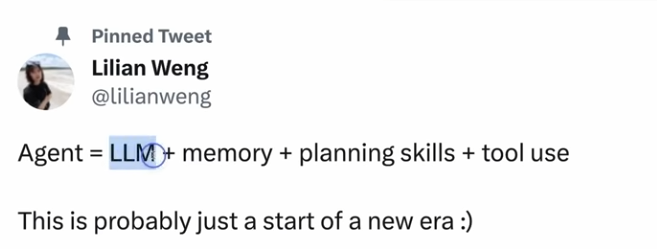

* 'wikipedia_search', which gives agent the ability to search wikipedia for a topic and summarize the text based on wikipedia api
* 'search', which gives agent the ability to perform a google search, based on SERPER
* 'scrape_website', which gives agent the ability to scrape a website and summarize the text based on browserless

inspiration: 

https://www.youtube.com/watch?v=KerHlb8nuVc

https://www.youtube.com/watch?v=biS8G8x8DdA&list=PL8motc6AQftk1Bs42EW45kwYbyJ4jOdiZ&index=20

https://www.youtube.com/watch?v=ogQUlS7CkYA&ab_channel=AIJason

### Wikipedia tool

In [3]:
wikipedia = WikipediaAPIWrapper()

Example usecase for wikipedia tool. When coming straight from langchain, the class has the built-in method 'run' which takes a string as input and returns a string as output. The input string is the topic to search for on wikipedia. The output string is the summary of the wikipedia page.

In [4]:
test_query_wikipedia = wikipedia.run('phoenix suns')
print(test_query_wikipedia)

Page: Phoenix Suns
Summary: The Phoenix Suns are an American professional basketball team based in Phoenix, Arizona. They compete in the National Basketball Association (NBA) as a member of the Pacific Division of the Western Conference. The Suns are the only team in their division not to be based in California. They play their home games at the Footprint Center. The Suns are one of four major league sports teams based in the Phoenix area, but are the only one to bill themselves as representing the city (the Cardinals, Coyotes, and Diamondbacks all bill themselves as representing the state of Arizona).
The franchise began play in 1968 as an expansion team. Though their early years were mired in mediocrity, their fortunes changed in the 1970s after partnering Dick Van Arsdale and Alvan Adams with Paul Westphal. The team reached the 1976 NBA Finals, in what is considered to be one of the biggest upsets in NBA history. However, after failing to capture a championship, the Suns would rebui

Tools require 3 parameters:
* name: name of the tool
* function: function to be called
* description: how your tool will be used in the agent

In [5]:
wikipedia_tool = Tool(
    name='wikipedia',
    func= wikipedia.run,
    description="Useful for when you need to look up a person, topic, or country on wikipedia"
)

### Duck Duck Go tool

In [7]:
duckduckgo = DuckDuckGoSearchRun()

In [8]:
test_query_duckduck = duckduckgo.run('phoenix suns')
print(test_query_duckduck)

View the Phoenix Suns's Official NBA Schedule, Roster & Standings. Watch Phoenix Suns's Games with NBA League Pass. Phoenix is now on their first winning streak since Nov. 24-26. Quick Recap The Suns led 36-30 after the first thanks to a strong effort to feed Jusuf Nurkic, who ended the first with 12 points and ... The Phoenix Suns, displaying effective ball movement that fueled scoring down low and from 3-point range, won their second-straight game, 133-119 over the Charlotte Hornets Friday at Footprint ... The Phoenix Suns ended a 3-game losing skid in convincing fashion Wednesday, defeating the Houston Rockets on the road, 129-113. Five Suns' players scored in double figures, with Kevin Durant ... HOUSTON (AP) — Kevin Durant had 27 points, 10 rebounds and a career-high 16 assists for his 18th career triple-double, helping the Phoenix Suns beat the Houston Rockets 129-113 on Wednesday night to snap a three-game losing streak. Durant was 9 of 16 from the field and also had two steals 

In [9]:
duckduckgo_tool = Tool(
    name="DuckDuckGo Search",
    func=duckduckgo.run,
    description="Useful for when you need to do a search on the internet to find information that another tool might not have"
)

### Python Read Evaluate Print Loop tool (Run Python code) tool

In [10]:
python_repl = PythonREPL()

In [11]:
python_repl.run("print(17*2)")

Python REPL can execute arbitrary code. Use with caution.


'34\n'

In [12]:
python_repl_tool = [
    Tool(
        name = "python repl",
        func=python_repl.run,
        description="useful for when you need to use python to answer a question. You should input python code"
    )
]

### Google Search Tool

In [13]:
# 1. Tool for searching
def google_search(query):
    url = "https://google.serper.dev/search"

    payload = json.dumps({"q": query})

    headers = {"X-API-KEY": serper_api_key, "Content-Type": "application/json"}

    response = requests.request("POST", url, headers=headers, data=payload)

    print(response.text)

    return response.text

In [14]:
google_search_tool = Tool(
        name="Search",
        func=google_search,
        description="useful for when you need to answer questions about current events, data. You should ask targeted questions",
    )

### Webscrape tool

In [15]:
# 2. Tool for scraping
def scrape_website(objective: str, url: str):
    # scrape website, and also will summarize the content based on objective if the content is too large
    # objective is the original objective & task that user give to the agent, url is the url of the website to be scraped

    print("Scraping website...")
    # Define the headers for the request
    headers = {
        "Cache-Control": "no-cache",
        "Content-Type": "application/json",
    }

    # Define the data to be sent in the request
    data = {"url": url}

    # Convert Python object to JSON string
    data_json = json.dumps(data)

    # Send the POST request
    post_url = f"https://chrome.browserless.io/content?token={browserless_api_key}"
    response = requests.post(post_url, headers=headers, data=data_json)

    # Check the response status code
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        text = soup.get_text()
        print("CONTENT:", text)

        if len(text) > 10000:
            output = summary(objective, text)
            return output
        else:
            return text
    else:
        print(f"HTTP request failed with status code {response.status_code}")


def summary(objective, content):
    llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k-0613")

    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n"], chunk_size=10000, chunk_overlap=500
    )
    docs = text_splitter.create_documents([content])
    map_prompt = """
    Write a summary of the following text for {objective}:
    "{text}"
    SUMMARY:
    """
    map_prompt_template = PromptTemplate(
        template=map_prompt, input_variables=["text", "objective"]
    )

    summary_chain = load_summarize_chain(
        llm=llm,
        chain_type="map_reduce",
        map_prompt=map_prompt_template,
        combine_prompt=map_prompt_template,
        verbose=True,
    )

    output = summary_chain.run(input_documents=docs, objective=objective)

    return output


# sample usage though very inefficient and expensive
# scrape_website(
#     objective="What is the history of the Phoenix Suns?", 
#     url="https://en.wikipedia.org/wiki/Phoenix_Suns",
#     )

In [16]:
# Scrape website tool is more complex with multiple inputs and has to be organized in a class
# Some of the functionality has to be pre-defined in the class
# The agent will figure out what information to pass to the class based on the Field description

class ScrapeWebsiteInput(BaseModel):
    """Inputs for scrape_website"""

    objective: str = Field(
        description="The objective & task that users give to the agent"
    )
    url: str = Field(description="The url of the website to be scraped")


class ScrapeWebsiteTool(BaseTool):
    name = "scrape_website"
    description = "useful when you need to get data from a website url, passing both url and objective to the function; DO NOT make up any url, the url should only be from the search results"
    args_schema: Type[BaseModel] = ScrapeWebsiteInput

    def _run(self, objective: str, url: str):
        return scrape_website(objective, url)

    def _arun(self, url: str):
        raise NotImplementedError("error here")

In [17]:
web_scrape_tool = ScrapeWebsiteTool()

# Initialize the agent, create the memory and toolbox

In [18]:
# from fastapi import FastAPI
load_dotenv()
browserless_api_key = os.getenv("BROWSERLESS_API_KEY")
serper_api_key = os.getenv("SERPER_API_KEY")

In [19]:
llm = ChatOpenAI(
    temperature=0, # temperature set to 0 because we're using it to make decisions
    model="gpt-3.5-turbo-16k-0613",
    )

In [43]:
# 3. Create langchain agent with the tools above

# appears that if the number of tools is greater than 3 this needs to be a dictionary
tools = [
    google_search_tool,
    web_scrape_tool,
    wikipedia_tool,
    #duckduckgo_tool,
    #python_repl_tool,
]

In [21]:
system_message = SystemMessage(
    content="""You are a world class researcher, who can do detailed research on any topic and produce facts based results; 
            you do not make things up, you will try as hard as possible to gather facts & data to back up the research
            
            Please make sure you complete the objective above with the following rules:
            1/ You should do enough research to gather as much information as possible about the objective
            2/ If there are url of relevant links & articles, you will scrape it to gather more information
            3/ After scraping & search, you should think "is there any new things i should search & scraping based on the data I collected to increase research quality?" If answer is yes, continue; But don't do this more than 3 iteratins
            4/ You should not make things up, you should only write facts & data that you have gathered
            5/ In the final output, You should include all reference data & links to back up your research; You should include all reference data & links to back up your research
            6/ In the final output, You should include all reference data & links to back up your research; You should include all reference data & links to back up your research"""
)

In [22]:
agent_kwargs = {
    "extra_prompt_messages": [MessagesPlaceholder(variable_name="memory")],
    "system_message": system_message,
}

In [23]:
memory = ConversationSummaryBufferMemory(
    memory_key="memory", 
    return_messages=True, 
    llm=llm, 
    max_token_limit=1000,
)

In [44]:
agent = initialize_agent(
    agent=AgentType.OPENAI_FUNCTIONS,
    llm=llm,
    tools=tools,
    verbose=True,
    agent_kwargs=agent_kwargs,
    memory=memory,
    max_iterations=5,
)

### Look at results

In [25]:
agent.agent.prompt#.messages[0].prompt.template

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input', 'memory'], input_types={'memory': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessage(content='You are a world class researcher, who can do detailed research on any topic and produce facts based results; \n            you do not make things up, you will try as hard as possible to gather facts & data to back up the research\n            \n            Please make 

In [27]:
agent.run("When was Barak Obama born?")



> Entering new AgentExecutor chain...

Invoking: `wikipedia` with `Barack Obama`


Page: Barack Obama
Summary: Barack Hussein Obama II (  bə-RAHK hoo-SAYN oh-BAH-mə; born August 4, 1961) is an American politician who served as the 44th president of the United States from 2009 to 2017. A member of the Democratic Party, he was the first African-American  president in U.S. history. Obama previously served as a U.S. senator representing Illinois from 2005 to 2008, as an Illinois state senator from 1997 to 2004, and as a civil rights lawyer and university lecturer. 
Obama was born in Honolulu, Hawaii. He graduated from Columbia University in 1983 with a B.A. in political science and later worked as a community organizer in Chicago. In 1988, Obama enrolled in Harvard Law School, where he was the first black president of the Harvard Law Review. He became a civil rights attorney and an academic, teaching constitutional law at the University of Chicago Law School from 1992 to 2004. He also we

'Barack Obama was born on August 4, 1961. [^1^]\n\nReference:\n[^1^]: [Wikipedia - Barack Obama](https://en.wikipedia.org/wiki/Barack_Obama)'

In [28]:
agent.run("Tell me about Singapore")



> Entering new AgentExecutor chain...

Invoking: `wikipedia` with `Singapore`


Page: Singapore
Summary: Singapore (  SING-(g)ə-por), officially the Republic of Singapore, is an island country and city-state in maritime Southeast Asia. It is located about one degree of latitude (137 kilometres or 85 miles) north of the equator, off the southern tip of the Malay Peninsula, bordering the Strait of Malacca to the west, the Singapore Strait to the south, the South China Sea to the east, and the Straits of Johor to the north. The country's territory comprises one main island, 63 satellite islands and islets, and one outlying islet; the combined area of these has increased by approximately 25% since the country's independence as a result of extensive land reclamation projects. It has the second highest population density of any country in the world, although there are numerous green and recreational spaces as a result of urban planning. With a multicultural population and in recognition of

"Singapore, officially known as the Republic of Singapore, is an island country and city-state located in maritime Southeast Asia. It is situated about 137 kilometers (85 miles) north of the equator, off the southern tip of the Malay Peninsula. Singapore is bordered by the Strait of Malacca to the west, the Singapore Strait to the south, the South China Sea to the east, and the Straits of Johor to the north. \n\nThe country consists of one main island, 63 satellite islands and islets, and one outlying islet. Over the years, Singapore has undergone extensive land reclamation projects, resulting in a 25% increase in its combined area since gaining independence. Despite its small size, Singapore has a high population density and is known for its urban planning that incorporates numerous green and recreational spaces.\n\nSingapore is a multicultural nation with a diverse population. It recognizes the cultural identities of its major ethnic groups, and as a result, has four official languag